In [1]:
import numpy as np
import scipy.linalg as linalg
from JSAnimation import IPython_display
import matplotlib.pyplot as plt
from matplotlib import animation
from multiprocessing import Pool, Manager, Process,TimeoutError
import time
import os

In [2]:
def generate_artificial_flow(size,p,T,omega):
    v_x,v_y = np.zeros(size),np.zeros(size);
    for x in range(size[0]):
        for y in range(size[1]):
            A = np.array([[-f,0,x],[0,-f,y]])
            B = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
            v_x[x,y],v_y[x,y] = np.dot(A,T)/p[x,y] + np.dot(B,omega)
    return v_x, v_y
    

In [6]:
size = (100,100)
p = np.zeros(size) + 45
p[:,30:40] = p[:,80:90] = 15
p[45:55,45:55] = 30
p[26:39,56:69] = 40
p[53:76,53:76] = 20
T = np.array([[0],[1],[0]])
omega = np.array([[0],[0],[0]])
f = 15

v_x,v_y = generate_artificial_flow(size,p,T,omega)

To be seen why the matrix is implemented in a reverse order

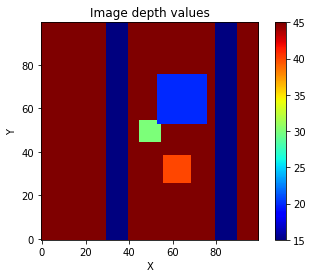

In [7]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(p, cmap="jet", origin="lower")
fig.colorbar(im)
ax.set_title('Image depth values')

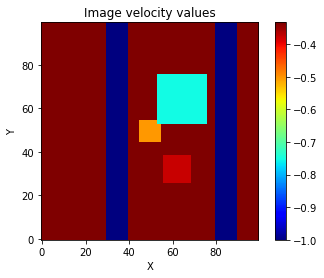

In [9]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(v_y, cmap="jet",origin="lower")
fig.colorbar(im)
ax.set_title('Image velocity values')

# Calculating the estimated translation

## Taking one sample into consideration

In [10]:
x_lim = size[0]
y_lim = size[1]
N = 10 #number of random points
f = 15 #focal length

sample_points = np.transpose([np.random.randint(1,80,size=N),np.random.randint(1,80,size=N)])
sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]

print(sample_v_x, sample_v_y, sample_points)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [-0.75       -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -1.         -0.75       -0.33333333] [[56 60]
 [20 42]
 [31 40]
 [18 18]
 [64 19]
 [28 69]
 [16 16]
 [ 6 36]
 [68 63]
 [ 5 10]]


In [12]:
def calculate_CT_estimate(sample_points, T): #input the presampled sample points - can be precalculated
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        
        #calculating A_T
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(x*y)/f, -(f + (x*x)/f), y])
        B[2*i+1] = np.array([f + (y*y)/f, -(x*y)/f, -x])
    return np.concatenate((A_T,B),axis=1)

def calculate_q(sample_points, omega, p):
    depths = np.transpose([p[sample_points[:,0],sample_points[:,1]]])
    inv_depths = 1/depths
    return np.vstack((inv_depths,omega))

In [13]:
CT = calculate_CT_estimate(sample_points, T)
q = calculate_q(sample_points,omega,p)
print(np.dot(CT,q))

[[ 0.        ]
 [-0.75      ]
 [ 0.        ]
 [-0.33333333]
 [ 0.        ]
 [-0.33333333]
 [ 0.        ]
 [-0.33333333]
 [ 0.        ]
 [-0.33333333]
 [ 0.        ]
 [-0.33333333]
 [ 0.        ]
 [-0.33333333]
 [ 0.        ]
 [-1.        ]
 [ 0.        ]
 [-0.75      ]
 [ 0.        ]
 [-0.33333333]]


### ^ This is expected because of the reverse engineering

We can literally recall because we have a value of the calculated velocities which were generatad from the artificial depth and the image generated from the sequence. 

In [14]:
def sample_T(): #to get a systematic number of T's (use for ||n later)
    for theta in np.arange(0,np.pi,0.01):
        for phi in np.arange(0,np.pi,0.01):
            x = np.cos(theta)*np.sin(phi)
            y = np.sin(theta)*np.sin(phi)
            z = np.cos(phi)
    return np.array([[x],[y],[z]])

def calculate_perp_CT(sample_points, T): #input the presampled sample points - **caution : orth may give errors**
    CT = calculate_CT_estimate(sample_points,T)
    return linalg.orth(CT)

def calculate_ET_perp(sample_points):
    N = np.shape(sample_points)[0];
    search_range = np.arange(0,np.pi,0.01)
    pool = Pool(CPU_NUMBER)
    
    def foo(T):
        return(calculate_perp_CT(sample_points,T))
    
    ET = pool.map(foo,search_range)
    pool.close()
    pool.join()

def calculate_ET_qr(sample_points, T):
    N = np.shape(sample_points)[0];
    CT = calculate_CT_estimate(sample_points,T)
    sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]
    v = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(2*N,1)
    CTbar, r = np.linalg.qr(CT)
    I = np.identity(2*N)
    cc = np.dot(CTbar,np.transpose(CTbar))
    E_T = (np.linalg.norm(np.dot((I - cc),v)))**2
    return E_T
    
    

In [15]:
sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]

In [16]:
%%time
## run through all candidate translation directions
search_range =np.arange(0,np.pi,0.01)
E = np.zeros((np.size(search_range),np.size(search_range)))

for idtheta,theta in enumerate(list(search_range)):
    for idphi,phi in enumerate(list(search_range)):
        x = np.cos(theta)*np.sin(phi)
        y = np.sin(theta)*np.sin(phi)
        z = np.cos(phi)
        T = np.array([[x],[y],[z]])

        CT = calculate_CT_estimate(sample_points, T)
        v_t = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(1,2*N) 
        #not sure where I got (-1) from but hey it works #v is concat of all sample point vels 
        v = np.transpose(v_t)
        CTbar, r = np.linalg.qr(CT)
        I = np.identity(2*N)
        cc = np.dot(CTbar,np.transpose(CTbar))
        E_T = (np.linalg.norm(np.dot((I - cc),v)))**2
        E[idtheta,idphi] += E_T

        
idtheta, idphi = np.unravel_index(E.argmin(), E.shape)
theta, phi = search_range[idtheta], search_range[idphi]
x_final = np.cos(theta)*np.sin(phi)
y_final = np.sin(theta)*np.sin(phi)
z_final = np.cos(phi)
T_final = np.array([[x_final],[y_final],[z_final]])
print(T_final)

[[  7.96326458e-04]
 [  9.99999366e-01]
 [  7.96326711e-04]]
CPU times: user 1min 53s, sys: 904 ms, total: 1min 54s
Wall time: 28.8 s


In [17]:
print(theta,phi)

1.57 1.57


In [22]:
E[150,280]

0.065775001512575162

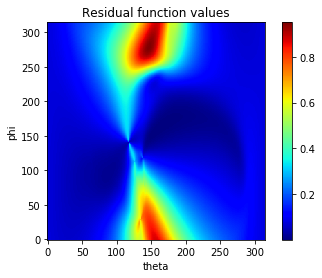

In [18]:
#plotting residual surfaces
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(E, cmap="jet",origin = "lower")
fig.colorbar(im)
ax.set_title('Residual function values')

In [19]:
search_range = np.arange(0,np.pi,0.01)
E = np.zeros((np.size(search_range),np.size(search_range)))
for x_split in np.arange(x_lim-1,0,-10):
    for y_split in np.arange(y_lim-1,0,-10):
        sample_points = np.transpose([np.random.randint(x_split-10,x_split,size=N),np.random.randint(y_split-10,y_split,size=N)])
        sample_v_x, sample_v_y = v_x[time,sample_points[:,0],sample_points[:,1]], v_y[time,sample_points[:,0],sample_points[:,1]]

        ## run through all candidate translation directions
        for idtheta,theta in enumerate(list(search_range)):
            for idphi,phi in enumerate(list(search_range)):
                x = np.cos(theta)*np.sin(phi)
                y = np.sin(theta)*np.sin(phi)
                z = np.cos(phi)
                T = np.array([[x],[y],[z]])

                CT = calculate_CT_estimate(sample_points, T)
                v_t = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(1,2*N) 
                #not sure where I got (-1) from but hey it works #v is concat of all sample point vels 
                CTbar, r = np.linalg.qr(CT)
                I = np.identity(2*N)
                cc = np.dot(CTbar,np.transpose(CTbar))
                E_T = (np.linalg.norm(np.dot((I - cc),v)))**2
                E[idtheta,idphi] += E_T

        theta, phi = np.unravel_index(E.argmin(), E.shape)
        x_final = np.cos(theta)*np.sin(phi)
        y_final = np.sin(theta)*np.sin(phi)
        z_final = np.cos(phi)y
        T_final = np.array([[x],[y],[z]])
        print(T)

SyntaxError: invalid syntax (<ipython-input-19-bc0ec5a8874d>, line 28)

In [ ]:
T = np.array([[0],[1],[0]])

CT = calculate_CT_estimate(sample_points, T)
q = calculate_q(sample_points,omega,p)
v_t = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(1,2*N) #v is concat of all sample point vels 
v = np.transpose(v_t)
perp_CT = calculate_perp_CT(sample_points, T)

CTbar, r = np.linalg.qr(CT)
I = np.identity(20)
cc = np.dot(CTbar,np.transpose(CTbar))

E_T1 = (np.linalg.norm(np.dot(v_t,linalg.orth(CT))))**2
E_T1_actual = (np.linalg.norm(np.dot((I - cc),v)))**2

print(E_T1_actual)


In [ ]:
%%time
for idtheta,theta in enumerate(list(search_range)):
    for idphi,phi in enumerate(list(search_range)):
        x = np.cos(theta)*np.sin(phi)
        y = np.sin(theta)*np.sin(phi)
        z = np.cos(phi)
        T = np.array([[x],[y],[z]])

        perp_CT = calculate_perp_CT(sample_points, T)
        v_t = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(1,2*N) #v is concat of all sample point vels 
        E_T = (np.linalg.norm(np.dot(v_t,perp_CT)))**2
        E[idtheta,idphi] = E_T

theta, phi = np.unravel_index(E.argmin(), E.shape)
x_final = np.cos(theta)*np.sin(phi)
y_final = np.sin(theta)*np.sin(phi)
z_final = np.cos(phi)
T_final = np.array([[x],[y],[z]])
print(T)

In [ ]:
#random linear algebra sanity check

C = np.random.rand(3,4)
Cbar, remove = np.linalg.qr(C)
()

In [ ]:
#plotting residual surfaces
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(E, cmap="jet")
fig.colorbar(im)
ax.set_title('Residual function values')